In [464]:
import streamlit as st
import pandas as pd
import pandas as pd
import altair as alt
import streamlit as st
import pandas as pd
import altair as alt
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np
from sklearn.preprocessing import  StandardScaler
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.metrics import  accuracy_score, roc_auc_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
import seaborn as sns


In [484]:
df = pd.read_csv('../data/british_airways_bookings.csv', encoding="ISO-8859-1", index_col=0, header=0,).reset_index()
df.head()



,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


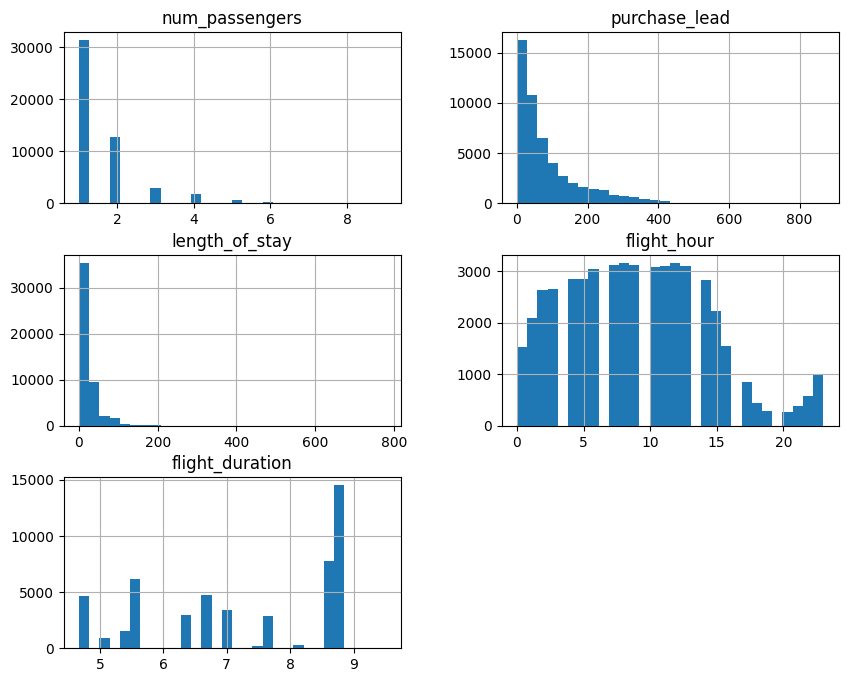

In [485]:
%matplotlib inline

numerical_columns = df.select_dtypes(include=['int64', 'float64']).nunique().loc[lambda x: x > 2].index.tolist()
df[numerical_columns].hist(bins=30, figsize=(10, 8))
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

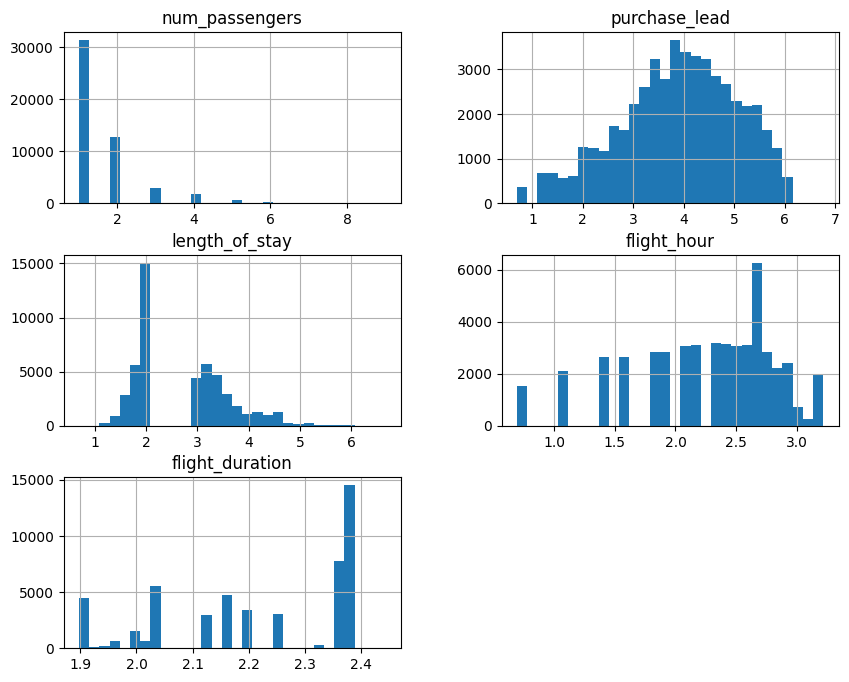

In [482]:
num_columns = ['purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
df_no_outliers = df.copy()
df_no_outliers[num_columns] = df_no_outliers[num_columns].apply(lambda x: np.log1p(x.clip(lower=0) + 1))
# Plot the histogram for the 'purchase_lead_log' column
df_no_outliers[numerical_columns].hist(bins=30, figsize=(10, 8))
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [486]:
for col in numerical_columns:
    print(f'{col}: min={df[col].min()}, max={df[col].max()}')

num_passengers: min=1, max=9
purchase_lead: min=0, max=867
length_of_stay: min=0, max=778
flight_hour: min=0, max=23
flight_duration: min=4.67, max=9.5


In [487]:
from sklearn.preprocessing import MinMaxScaler
df_scaled = df.copy()
min_max_scaler = MinMaxScaler()
df_scaled[numerical_columns] = min_max_scaler.fit_transform(df_scaled[numerical_columns])

In [504]:
df['booking_origin'].unique()

array(['New Zealand', 'India', 'United Kingdom', 'China', 'South Korea',
       'Japan', 'Malaysia', 'Singapore', 'Switzerland', 'Germany',
       'Indonesia', 'Czech Republic', 'Vietnam', 'Thailand', 'Spain',
       'Romania', 'Ireland', 'Italy', 'Slovakia', 'United Arab Emirates',
       'Tonga', 'Réunion', '(not set)', 'Saudi Arabia', 'Netherlands',
       'Qatar', 'Hong Kong', 'Philippines', 'Sri Lanka', 'France',
       'Croatia', 'United States', 'Laos', 'Hungary', 'Portugal',
       'Cyprus', 'Australia', 'Cambodia', 'Poland', 'Belgium', 'Oman',
       'Bangladesh', 'Kazakhstan', 'Brazil', 'Turkey', 'Kenya', 'Taiwan',
       'Brunei', 'Chile', 'Bulgaria', 'Ukraine', 'Denmark', 'Colombia',
       'Iran', 'Bahrain', 'Solomon Islands', 'Slovenia', 'Mauritius',
       'Nepal', 'Russia', 'Kuwait', 'Mexico', 'Sweden', 'Austria',
       'Lebanon', 'Jordan', 'Greece', 'Mongolia', 'Canada', 'Tanzania',
       'Peru', 'Timor-Leste', 'Argentina', 'New Caledonia', 'Macau',
       'Myanmar (

In [505]:
df['num_passengers'].min()

np.int64(1)

In [488]:
for col in numerical_columns:
    print(f'{col}: min={df_scaled[col].min()}, max={df_scaled[col].max()}')

num_passengers: min=0.0, max=1.0
purchase_lead: min=0.0, max=1.0
length_of_stay: min=0.0, max=0.9999999999999999
flight_hour: min=0.0, max=1.0
flight_duration: min=0.0, max=0.9999999999999999


In [489]:
categorical_features = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']
df_encoded = pd.get_dummies(df_scaled, columns = categorical_features,)
df_encoded


,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,sales_channel_Internet,...,booking_origin_Timor-Leste,booking_origin_Tonga,booking_origin_Tunisia,booking_origin_Turkey,booking_origin_Ukraine,booking_origin_United Arab Emirates,booking_origin_United Kingdom,booking_origin_United States,booking_origin_Vanuatu,booking_origin_Vietnam
0,0.125,0.302191,0.024422,0.304348,1,0,0,0.175983,0,True,...,False,False,False,False,False,False,False,False,False,False
1,0.000,0.129181,0.025707,0.130435,0,0,0,0.175983,0,True,...,False,False,False,False,False,False,False,False,False,False
2,0.125,0.280277,0.028278,0.739130,1,1,0,0.175983,0,True,...,False,False,False,False,False,False,False,False,False,False
3,0.000,0.110727,0.039846,0.173913,0,0,1,0.175983,0,True,...,False,False,False,False,False,False,False,False,False,False
4,0.125,0.078431,0.028278,0.652174,1,0,1,0.175983,0,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.125,0.031142,0.007712,0.391304,1,0,1,0.196687,0,True,...,False,False,False,False,False,False,False,False,False,False
49996,0.000,0.128028,0.007712,0.173913,0,0,0,0.196687,0,True,...,False,False,False,False,False,False,False,False,False,False
49997,0.000,0.027682,0.007712,0.956522,0,0,1,0.196687,0,True,...,False,False,False,False,False,False,False,False,False,False
49998,0.000,0.017301,0.007712,0.478261,1,0,1,0.196687,0,True,...,False,False,False,False,False,False,False,False,False,False


In [490]:
x=df_encoded.drop("booking_complete",axis=1)
y=df_encoded["booking_complete"]
from sklearn.model_selection import train_test_split
np.random.seed(42)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [491]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
model=RandomForestClassifier(n_estimators=1000)
model.fit(x_train,y_train)
model.score(x_test,y_test)

0.8548

In [443]:
# Save the model
filename = 'british_airways_random_forest.pkl'
pickle.dump(model, open(filename, 'wb'))

In [448]:
# Save the model
filename = 'british_airways_logistic_regression.pkl'
pickle.dump(model, open(filename, 'wb'))

In [492]:
def predict_booking_complete(num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration):
    
    # Load the model
    model = pickle.load(open('british_airways_random_forest.pkl', 'rb'))
    # Create a dataframe with the new data
    new_data = pd.DataFrame({'num_passengers': [num_passengers],
                             'sales_channel': [sales_channel],
                             'trip_type': [trip_type],
                             'purchase_lead': [purchase_lead],
                             'length_of_stay': [length_of_stay],
                             'flight_hour': [flight_hour],
                             'flight_day': [flight_day],
                             'route': [route],
                             'booking_origin': [booking_origin],
                             'wants_extra_baggage': [wants_extra_baggage],
                             'wants_preferred_seat': [wants_preferred_seat],
                             'wants_in_flight_meals': [wants_in_flight_meals],
                             'flight_duration': [flight_duration]})
    # Preprocess the data
    num_columns = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
    cat_columns = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']
    #Log transform the numerical columns
    new_data[num_columns] = new_data[num_columns].apply(lambda x: np.log1p(x.clip(lower=0) + 1))
    #Min-max scale the numerical columns
    scaler = StandardScaler()
    new_data[num_columns] = scaler.fit_transform(new_data[num_columns])
    #One-hot encode the categorical columns
    new_data = pd.get_dummies(new_data, columns=cat_columns)
    # Ensure the new data has the same columns as the training data
    new_data = new_data.reindex(columns=x.columns, fill_value=0)

    # Make a prediction
    prediction = model.predict(new_data)
    return prediction

In [494]:
predict_booking_complete(3, 'Internet', 'CircleTrip', 30, 7, 10, 'Mon', 'AKLDEL', 'Malaysia', 1, 1, 1, 8)

array([1])